In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import gc
from sklearn.model_selection import KFold, train_test_split, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import wilcoxon


In [5]:
df_attack = pd.read_csv('CICIDSFULLOnlyAttacks.csv')
df_normal = pd.read_csv('CICIDSFULLOnlyNormal.csv')

In [14]:
dataframe = {
    'Benign': 0, 'DDOS attack-HOIC': 1, 'DDoS attacks-LOIC-HTTP': 1,
    'DoS attacks-Hulk': 1, 'Bot': 1, 'FTP-BruteForce': 1,
    'SSH-Bruteforce': 1, 'Infilteration': 1,
    'DoS attacks-SlowHTTPTest': 1, 'DoS attacks-GoldenEye': 1,
    'DoS attacks-Slowloris': 1, 'DDOS attack-LOIC-UDP': 1,
    'Brute Force -Web': 1, 'Brute Force -XSS': 1, 'SQL Injection': 1
}

df_attack.replace(dataframe, inplace=True)
df_normal.replace(dataframe, inplace=True)
df_x = pd.concat([df_attack, df_normal])

C:\Users\mikae\AppData\Local\Temp\ipykernel_8312\277015827.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_attack.replace(dataframe, inplace=True)
C:\Users\mikae\AppData\Local\Temp\ipykernel_8312\277015827.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_normal.replace(dataframe, inplace=True)


In [15]:
df_x = pd.concat([df_attack, df_normal])

### Reduzindo dimensionalidade com PCA, mantendo 95% de variância

In [16]:
X = df_x.drop(columns=['label'])
y = df_x['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [18]:
pca.n_components_

np.int64(24)

In [ ]:
pca_columns = pd.DataFrame(pca.components_, columns=X.columns)
caluculo_features = pca_columns.abs().mean(axis=0).sort_values(ascending=False)
features_representativas = caluculo_features.index[:pca.n_components_]
df_reduzido_PCA = pd.concat([df_x[features_representativas].reset_index(drop=True), y.reset_index(drop=True)], axis=1)
df_reduzido_PCA.columns = list(features_representativas) + ['label']
df_reduzido_PCA.to_csv('df_reduzido_PCA.csv', index=False)

In [ ]:
df_reduzido_PCA.to_csv('df_reduzido_PCA.csv', index=False)
#df_reduzido_PCA = pd.read_csv("df_reduzido_PCA.csv")
#df_reduzido_PCA['label'].value_counts()

### Imputação de dados faltantes -
Primeiramente, uma pequena amostra de cada classe do conjunto de dados é extraída e concatenada para formar o dataset df_instancia. Em seguida, alguns valores desse novo dataset são substituídos aleatoriamente por NaN. Por fim, esses valores ausentes são preenchidos utilizando a mediana de cada coluna

In [ ]:
classe_1 = df_reduzido_PCA[df_reduzido_PCA['label'] == 1].sample(n=2500, random_state=42)
classe_0 = df_reduzido_PCA[df_reduzido_PCA['label'] == 0].sample(n=2500, random_state=42)
df_instancia = pd.concat([classe_1, classe_0])



In [ ]:
frac = 0.5
mask = np.random.rand(*df_instancia.shape) < frac
df_normal_NaN = df_instancia.mask(mask)
df_normal_NaN

,flow_byts/s,init_fwd_win_byts,down/up_ratio,pkt_len_var,dst_port,init_bwd_win_byts,urg_flag_cnt,bwd_iat_min,ece_flag_cnt,rst_flag_cnt,...,bwd_iat_std,active_min,fwd_seg_size_min,fwd_pkt_len_min,pkt_len_min,bwd_pkts/s,flow_pkts/s,idle_min,fin_flag_cnt,label
2321387,743.537121,NaN,NaN,NaN,NaN,NaN,0.0,42.0,1.0,NaN,...,763733.384400,0.0,NaN,NaN,0.0,NaN,5.289390,NaN,0.0,1.0
1742120,NaN,NaN,NaN,NaN,80.0,-1.0,0.0,0.0,0.0,0.0,...,0.000000,NaN,32.0,0.0,0.0,0.000000,60.892069,0.0,0.0,1.0
2194872,1048.564298,8192.0,1.0,115523.428600,80.0,NaN,NaN,15.0,1.0,NaN,...,541401.019600,0.0,20.0,0.0,0.0,4.262456,7.459299,NaN,NaN,1.0
2575634,NaN,NaN,1.0,115523.428600,80.0,NaN,NaN,NaN,1.0,1.0,...,894594.150100,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
289455,0.000000,32738.0,0.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,...,0.000000,NaN,20.0,0.0,NaN,0.000000,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843736,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4084606,NaN,NaN,0.0,508.890909,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,20.0,0.0,NaN,0.026673,NaN,53880402.0,0.0,0.0
3591464,NaN,-1.0,1.0,NaN,53.0,NaN,NaN,NaN,0.0,0.0,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4480845,1512.480628,-1.0,1.0,1153.200000,NaN,NaN,0.0,NaN,NaN,0.0,...,0.000000,0.0,8.0,40.0,NaN,NaN,21.302544,0.0,0.0,NaN


In [58]:
tem_NaN = df_normal_NaN.isna().any().any()
tem_NaN

np.True_

In [ ]:
df_normal_NaN = df_normal_NaN.drop('label', axis=1)

#Imputação de da medianas nos valores NaN
for coluna in df_normal_NaN.columns:
    df_normal_NaN[coluna] = df_normal_NaN[coluna].fillna(df_normal_NaN[coluna].median())

In [60]:
df_normal_NaN

,flow_byts/s,init_fwd_win_byts,down/up_ratio,pkt_len_var,dst_port,init_bwd_win_byts,urg_flag_cnt,bwd_iat_min,ece_flag_cnt,rst_flag_cnt,...,bwd_iat_mean,bwd_iat_std,active_min,fwd_seg_size_min,fwd_pkt_len_min,pkt_len_min,bwd_pkts/s,flow_pkts/s,idle_min,fin_flag_cnt
2321387,743.537121,8192.0,0.0,192.200000,80.0,0.0,0.0,42.0,1.0,0.0,...,0.0,763733.384400,0.0,20.0,0.0,0.0,2.326015,5.289390,0.0,0.0
1742120,72.160595,8192.0,0.0,192.200000,80.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,32.0,0.0,0.0,0.000000,60.892069,0.0,0.0
2194872,1048.564298,8192.0,1.0,115523.428600,80.0,0.0,0.0,15.0,1.0,0.0,...,0.0,541401.019600,0.0,20.0,0.0,0.0,4.262456,7.459299,0.0,0.0
2575634,72.160595,8192.0,1.0,115523.428600,80.0,0.0,0.0,0.0,1.0,1.0,...,0.0,894594.150100,0.0,20.0,0.0,0.0,2.326015,172.393207,0.0,0.0
289455,0.000000,32738.0,0.0,192.200000,80.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,20.0,0.0,0.0,0.000000,172.393207,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843736,72.160595,8192.0,0.0,192.200000,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,20.0,0.0,0.0,2.326015,172.393207,0.0,0.0
4084606,72.160595,8192.0,0.0,508.890909,80.0,0.0,0.0,0.0,0.0,0.0,...,29173012.5,0.000000,0.0,20.0,0.0,0.0,0.026673,172.393207,53880402.0,0.0
3591464,72.160595,-1.0,1.0,192.200000,53.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,20.0,0.0,0.0,2.326015,172.393207,0.0,0.0
4480845,1512.480628,-1.0,1.0,1153.200000,80.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.000000,0.0,8.0,40.0,0.0,2.326015,21.302544,0.0,0.0


### Análise exploratória

In [9]:
instancia_df_normal = df_normal
instancia_df_attack = df_attack
df_instancia = pd.concat([instancia_df_normal, instancia_df_attack])


df_eda = df_instancia[['flow_byts/s', 'init_fwd_win_byts', 'down/up_ratio', 'pkt_len_var', 'dst_port',
             'init_bwd_win_byts', 'urg_flag_cnt', 'bwd_iat_min',
             'ece_flag_cnt', 'rst_flag_cnt', 'label']]



**Pairplot**

<Figure size 1600x1200 with 0 Axes>

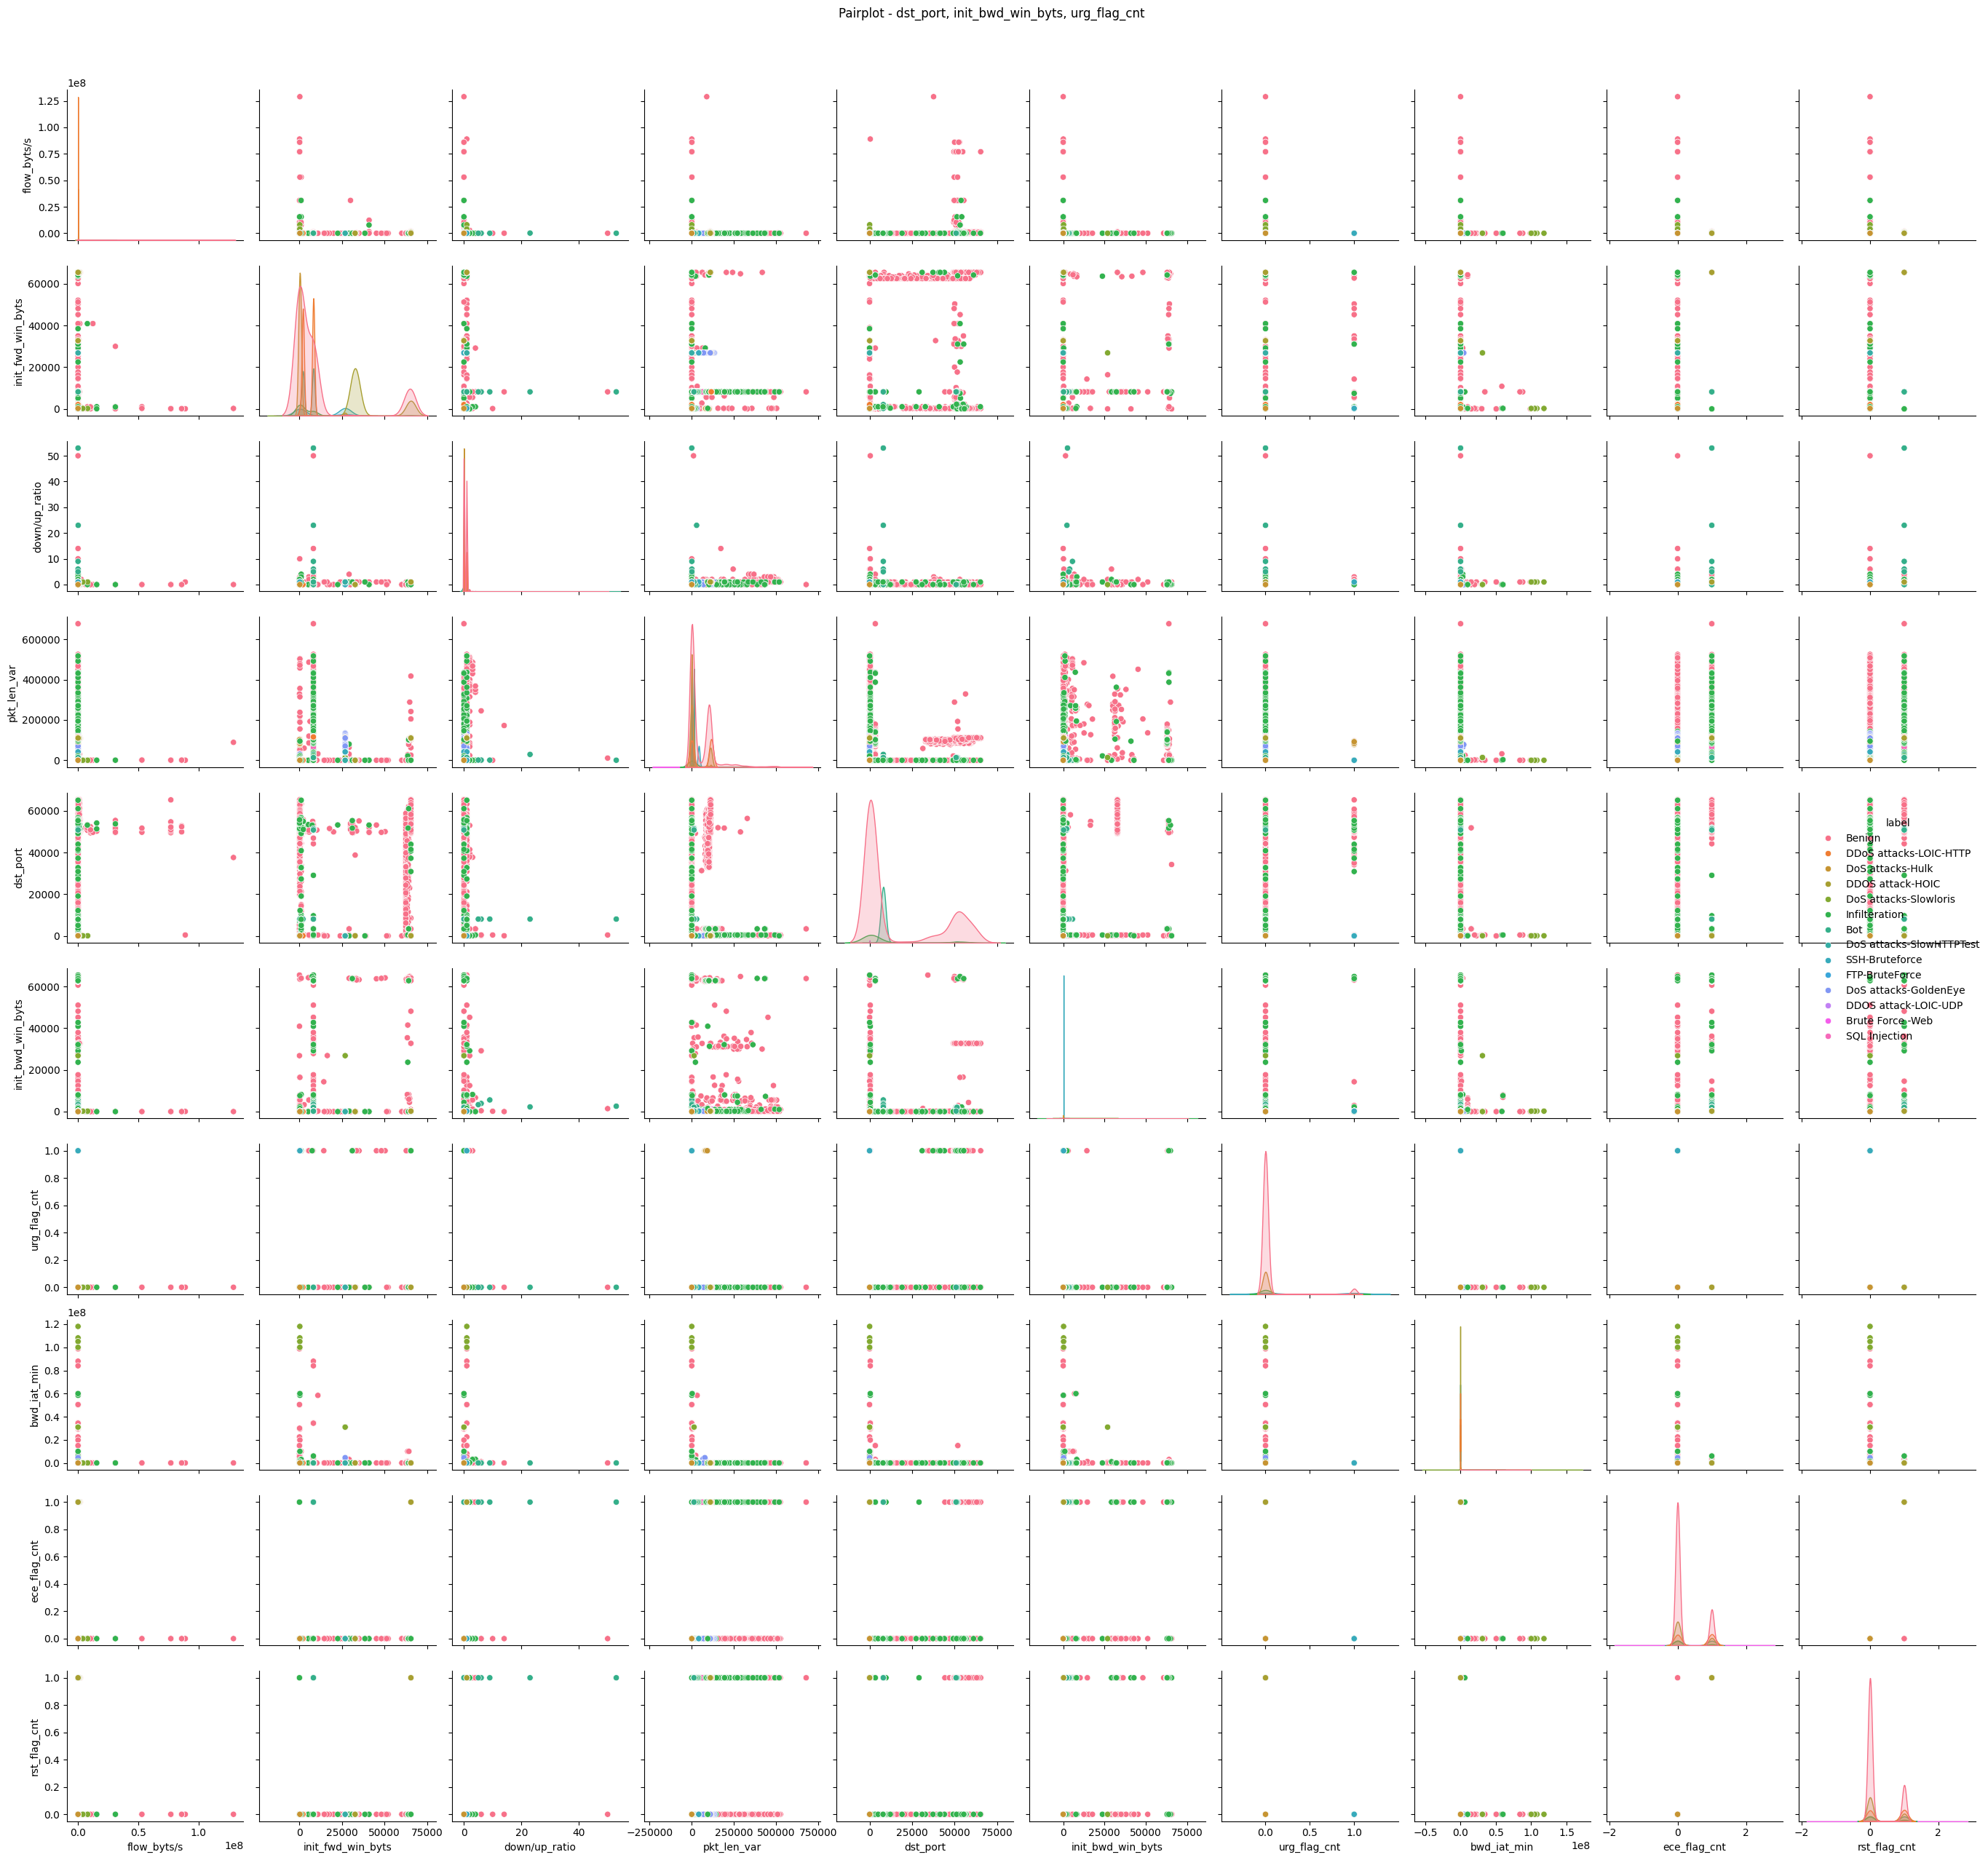

In [ ]:
plt.figure(figsize=(16, 12))
sns.pairplot(df_eda, hue='label')
plt.suptitle('Features', y=1.02)

plt.tight_layout()
plt.show()


<Axes: >

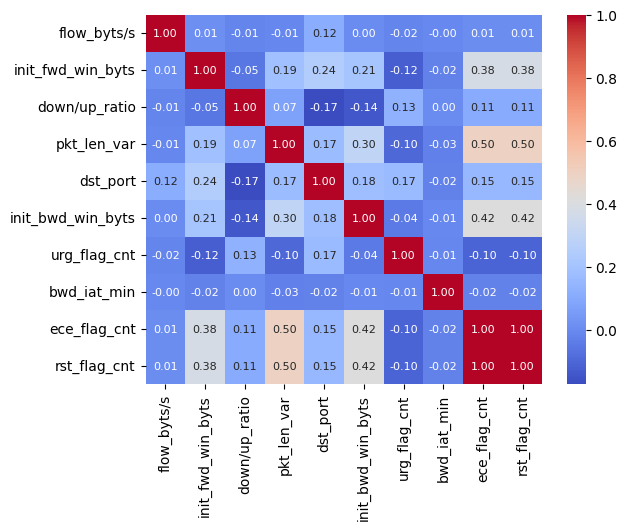

In [23]:
dataframe = {
    'Benign': 0, 'DDOS attack-HOIC': 1, 'DDoS attacks-LOIC-HTTP': 1,
    'DoS attacks-Hulk': 1, 'Bot': 1, 'FTP-BruteForce': 1,
    'SSH-Bruteforce': 1, 'Infilteration': 1,
    'DoS attacks-SlowHTTPTest': 1, 'DoS attacks-GoldenEye': 1, 'DoS attacks-Slowloris': 1,
    'DDOS attack-LOIC-UDP': 1, 'Brute Force -Web': 1, 'Brute Force -XSS': 1, 'SQL Injection': 1
}
df_eda1 = df_eda.copy()
df_eda1.replace(dataframe, inplace=True)
x = df_eda1.drop('label', axis=1)
r = x.corr(method='pearson')
sns.heatmap(r, annot=True, cmap='coolwarm', 
            fmt=".2f", annot_kws={"size": 8, 
                                  "ha": 'center', 
                                  "va": 'center'})


**Gráfico setorial**

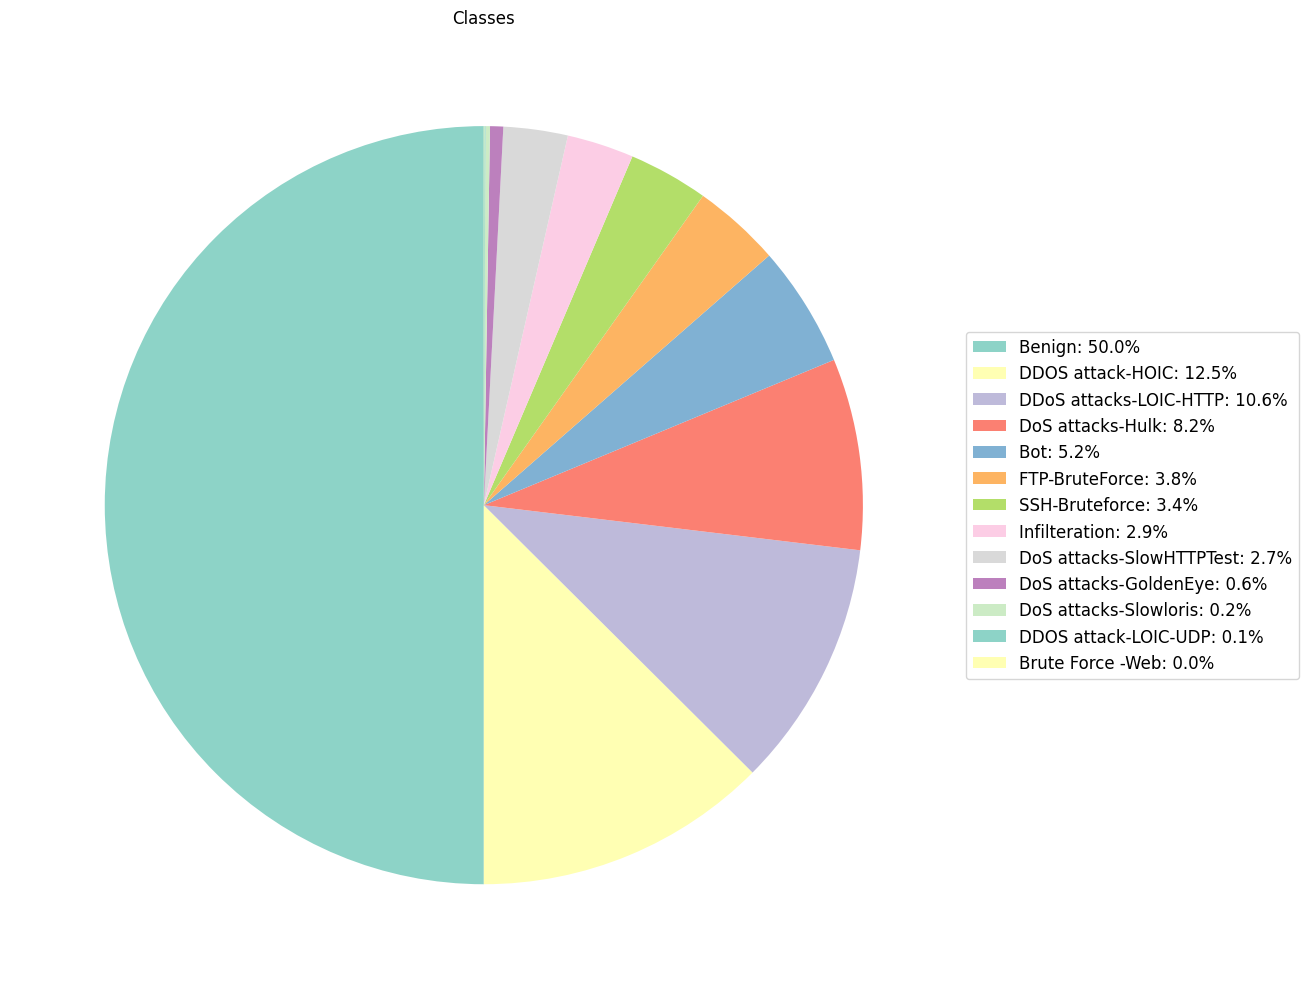

In [5]:
colors = sns.color_palette("Set3", 11)

plt.figure(figsize=(18, 10))
feature = df_eda['label'].value_counts()
percentages = feature / feature.sum() * 100 

plt.pie(feature, startangle=90, colors=colors, pctdistance=0.85, labeldistance=1.1)

plt.title('Classes')

legend_labels = [f"{label}: {percentage:.1f}%" for label, percentage in zip(feature.index, percentages)]

plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout()
plt.show()


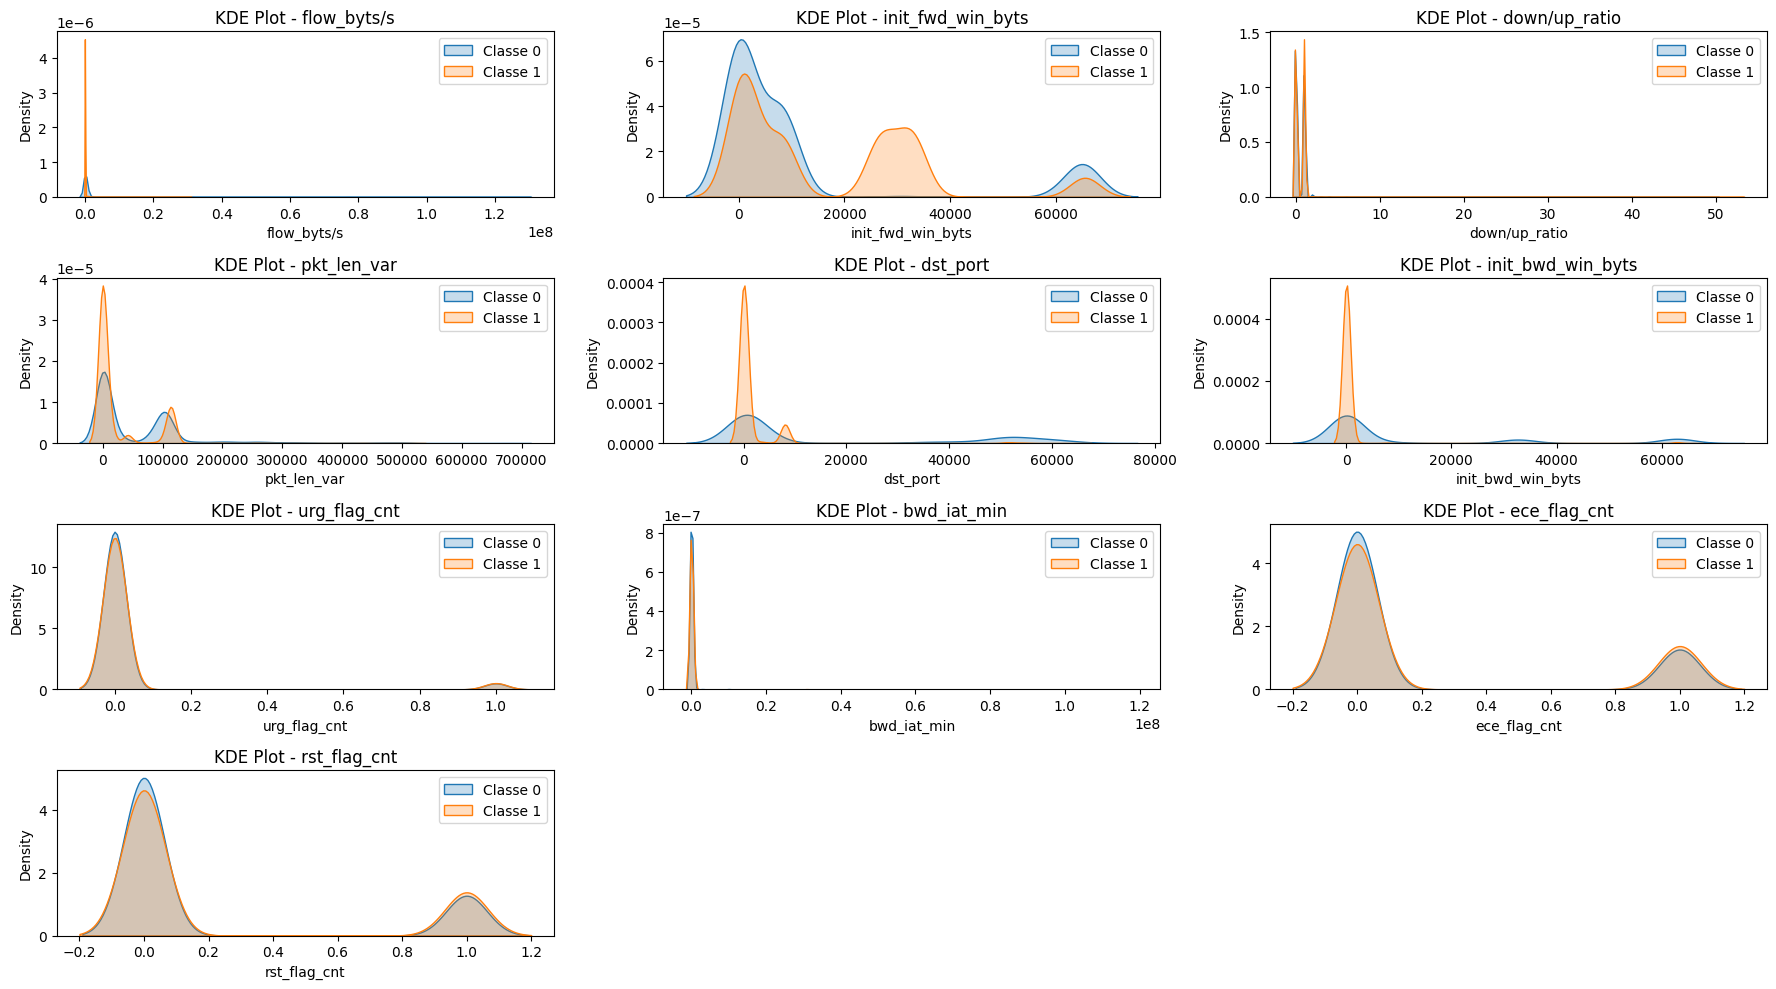

In [ ]:
plt.figure(figsize=(18, 10))

num_features = df_eda1.select_dtypes(include=['number']).columns
num_features = num_features[num_features != 'label']
num_rows = (len(num_features) // 3) + (1 if len(num_features) % 3 != 0 else 0)

for i, feature in enumerate(num_features):
    plt.subplot(num_rows, 3, i+1)
    
    class_0_data = df_eda1[df_eda1['label'] == 0][feature]
    class_1_data = df_eda1[df_eda1['label'] == 1][feature]
    if class_0_data.nunique() > 1:
        sns.kdeplot(class_0_data, fill=True, label='Classe 0')
    if class_1_data.nunique() > 1:
        sns.kdeplot(class_1_data, fill=True, label='Classe 1')
    
    plt.title(f'KDE Plot - {feature}')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
dataframe = {
    'Benign': 0, 'DDOS attack-HOIC': 1, 'DDoS attacks-LOIC-HTTP': 2,
    'DoS attacks-Hulk': 3, 'Bot': 4, 'FTP-BruteForce': 5,
    'SSH-Bruteforce': 6, 'Infilteration': 7,
    'DoS attacks-SlowHTTPTest': 8, 'DoS attacks-GoldenEye': 9, 'DoS attacks-Slowloris': 10,
    'DDOS attack-LOIC-UDP': 11, 'Brute Force -Web': 12, 'Brute Force -XSS': 13, 'SQL Injection': 14
}
df_eda2 = df_eda.copy()
df_eda2.replace(dataframe, inplace=True)

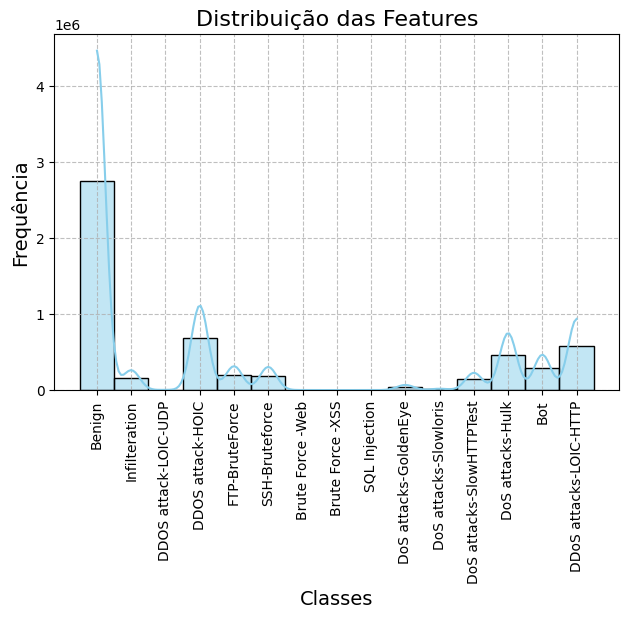

In [10]:
df_eda2 = df_eda.copy()
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
sns.histplot(df_eda2['label'], kde=True, bins=50, color='skyblue')

# Ajustando título e rótulos
plt.title('Distribuição das Features', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Frequência', fontsize=14)

# Rotacionando as legendas do eixo x
plt.xticks(rotation=90)

# Melhorar o grid
plt.grid(True, linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()



# Normalização minmax/Std Scaler, abordagem KFold (10), gridsearch com pelo menos 4 algoritmos.
 - Acurácia
 - Precision 
 - Recall
 - F1
 - Wilcoxon


In [12]:
df_reduzido_PCA_Teste = pd.read_csv("df_reduzido_PCA.csv")
df_teste_producao = df_reduzido_PCA_Teste.sample(frac=0.2, random_state=42)
df_reduzido_PCA = df_reduzido_PCA_Teste.drop(df_teste_producao.index)

In [11]:
df_teste_producao.to_csv('df_teste_producao.csv', index=False)

NameError: name 'df_teste_producao' is not defined

In [24]:
df_reduced_percent = df_reduzido_PCA.sample(frac=0.001, 
                                            random_state=42)

x = df_reduced_percent.drop('label', axis = 1)
y = df_reduced_percent['label']

x1 = x.values
y1 = y.values

In [14]:
# Hiperparâmetros KNN
param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 9, 11,],
    'metric': ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'braycurtis', 'correlation']
}

# Hiperparâmetros Decision Tree (DT)
param_grid_DT = {
    'max_depth': [3, 6, 7, 9, 11]
}

# Hiperparâmetros Random Forest (RF)
param_grid_RF = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

# Hiperparâmetros XGBoost (XGB)
param_grid_XGB = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

#Arrays de metricas
test_scores_KNN, precision_scores_KNN, recall_scores_KNN, f1_scores_KNN, accs_KNN, par_KNN = [], [], [], [], [], []
test_scores_DT, precision_scores_DT, recall_scores_DT, f1_scores_DT, accs_DT, par_DT = [], [], [], [], [], []
test_scores_RF, precision_scores_RF, recall_scores_RF, f1_scores_RF, accs_RF, par_RF = [], [], [], [], [], []
test_scores_XGB, precision_scores_XGB, recall_scores_XGB, f1_scores_XGB, accs_XGB, par_XGB = [], [], [], [], [], []

#Instanciação do K-folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

#Instanciação do StandardScaler
scaler = StandardScaler()


In [25]:
for train_index, test_index in kf.split(x1):
    X_train, X_test = x1[train_index], x1[test_index]
    Y_train, Y_test = y1[train_index], y1[test_index]

    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, Y_train, 
                                                                        random_state=42, 
                                                                        test_size=0.2)


    ############################################################################################################################
    # K-Nearest Neighbors - KNN
    for params in ParameterGrid(param_grid_KNN):
                
        X_train_val_KNN = scaler.fit_transform(X_train_val)
        X_test_val_KNN = scaler.transform(X_test_val)
    
        knn = KNeighborsClassifier(n_neighbors=params['n_neighbors'],
                                   metric=params['metric'], n_jobs=-1)
        
        knn.fit(X_train_val, y_train_val)
        y_pred = knn.predict(X_test_val)
        
        acc = accuracy_score(y_test_val, y_pred)
        accs_KNN.append(acc)
        par_KNN.append(params)
        
    X_train_KNN = scaler.fit_transform(X_train)
    X_test_KNN = scaler.transform(X_test)

    best_params_KNN = par_KNN[accs_KNN.index(max(accs_KNN))]
    knn_best = KNeighborsClassifier(metric=best_params_KNN['metric'], 
                                    n_neighbors=best_params_KNN['n_neighbors'],
                                    n_jobs=-1)
    
    knn_best.fit(X_train_KNN, Y_train)
    y_pred = knn_best.predict(X_test_KNN)
    
    test_scores_KNN.append(accuracy_score(Y_test, y_pred))
    precision_scores_KNN.append(precision_score(Y_test, y_pred, average='weighted'))
    recall_scores_KNN.append(recall_score(Y_test, y_pred, average='weighted'))
    f1_scores_KNN.append(f1_score(Y_test, y_pred, average='weighted'))
    
    ############################################################################################################################
    # Decision Tree - DT
    for max_depth in param_grid_DT['max_depth']:
                
        X_train_val_DT = scaler.fit_transform(X_train_val)
        X_test_val_DT = scaler.transform(X_test_val)
        
        dt = DecisionTreeClassifier(max_depth=max_depth, 
                                    max_features='log2',
                                    random_state=42)
        
        dt.fit(X_train_val_DT, y_train_val)
        y_pred = dt.predict(X_test_val_DT)
        
        acc = accuracy_score(y_test_val, y_pred)
        accs_DT.append(acc)
        par_DT.append(max_depth)
            
    X_train_DT = scaler.fit_transform(X_train)
    X_test_DT = scaler.transform(X_test)

    dt_best = DecisionTreeClassifier(max_depth=par_DT[accs_DT.index(max(accs_DT))],
                                     max_features='log2', random_state=42)
    dt_best.fit(X_train, Y_train)
    y_pred = dt_best.predict(X_test)
    
    test_scores_DT.append(accuracy_score(Y_test, y_pred))
    precision_scores_DT.append(precision_score(Y_test, y_pred, average='weighted'))
    recall_scores_DT.append(recall_score(Y_test, y_pred, average='weighted'))
    f1_scores_DT.append(f1_score(Y_test, y_pred, average='weighted'))

    ############################################################################################################################
    # Random Forest - RF
    for params in ParameterGrid(param_grid_RF):
          
        X_train_val_RF = scaler.fit_transform(X_train_val)
        X_test_val_RF = scaler.transform(X_test_val)
        
        rf = RandomForestClassifier(n_estimators=params['n_estimators'],
                                    random_state=42, max_features='sqrt',
                                    n_jobs=-1, verbose=1)
        
        rf.fit(X_train_val_RF, y_train_val)
        y_pred = rf.predict(X_test_val_RF)
        
        acc = accuracy_score(y_test_val, y_pred)
        accs_RF.append(acc)
        par_RF.append(params)
        
    X_train_RF = scaler.fit_transform(X_train)
    X_test_RF = scaler.transform(X_test)

    best_param_RF = par_RF[accs_RF.index(max(accs_RF))]
    rf_best = RandomForestClassifier(**best_param_RF, random_state=42,
                                     max_features='sqrt',
                                     n_jobs=-1, verbose=1)
    
    rf_best.fit(X_train, Y_train)
    y_pred = rf_best.predict(X_test)

    test_scores_RF.append(accuracy_score(Y_test, y_pred))
    precision_scores_RF.append(precision_score(Y_test, y_pred, average='weighted'))
    recall_scores_RF.append(recall_score(Y_test, y_pred, average='weighted'))
    f1_scores_RF.append(f1_score(Y_test, y_pred, average='weighted'))

    ############################################################################################################################
    # XGBoost _ XGB
    for params in ParameterGrid(param_grid_XGB):
        
        X_train_val_XGB = scaler.fit_transform(X_train_val)
        X_test_val_XGB = scaler.transform(X_test_val)
        
        xgb = XGBClassifier(n_estimators=params['n_estimators'],
                            max_depth=params['max_depth'],
                            learning_rate=params['learning_rate'],
                            n_jobs=-1, random_state=42, 
                            use_label_encoder=False, eval_metric='logloss',
                            tree_method='hist')
        
        xgb.fit(X_train_val_XGB, y_train_val)
        y_pred = xgb.predict(X_test_val_XGB)
        acc = accuracy_score(y_test_val, y_pred)
        accs_XGB.append(acc)
        par_XGB.append(params)
        
    X_train_XGB = scaler.fit_transform(X_train)
    X_test_XGB = scaler.transform(X_test)

    best_params = par_XGB[accs_XGB.index(max(accs_XGB))]
    xgb_best = XGBClassifier(**best_params, random_state=42,
                             use_label_encoder=False,
                             eval_metric='logloss',
                             tree_method='hist')
    
    xgb_best.fit(X_train, Y_train)
    y_pred = xgb_best.predict(X_test)
    
    test_scores_XGB.append(accuracy_score(Y_test, y_pred))
    precision_scores_XGB.append(precision_score(Y_test, y_pred, average='weighted'))
    recall_scores_XGB.append(recall_score(Y_test, y_pred, average='weighted'))
    f1_scores_XGB.append(f1_score(Y_test, y_pred, average='weighted'))
    
    
    data = {
    "Modelo": ["KNN", "DT", "RF", "XGB"],
    
    "Acurácia": [np.mean(test_scores_KNN), np.mean(test_scores_DT),
                 np.mean(test_scores_RF), np.mean(test_scores_XGB)],
    
    "Precisão": [np.mean(precision_scores_KNN), np.mean(precision_scores_DT),
                 np.mean(precision_scores_RF), np.mean(precision_scores_XGB)],
    
    "Recall": [np.mean(recall_scores_KNN), np.mean(recall_scores_DT),
               np.mean(recall_scores_RF), np.mean(recall_scores_XGB)],
    
    "F1 Score": [np.mean(f1_scores_KNN), np.mean(f1_scores_DT),
                 np.mean(f1_scores_RF), np.mean(f1_scores_XGB)]
}

metrics = pd.DataFrame(data)
metrics



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s f

,Modelo,Acurácia,Precisão,Recall,F1 Score
0,KNN,0.952480,0.954400,0.952480,0.952422
1,DT,0.934664,0.936441,0.934664,0.934657
2,RF,0.958994,0.960460,0.958994,0.959013
3,XGB,0.962554,0.963689,0.962554,0.962551


In [ ]:
for train_index, test_index in kf.split(x1):
    X_train, X_test = x1[train_index], x1[test_index]
    Y_train, Y_test = y1[train_index], y1[test_index]

    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, Y_train, 
                                                                        random_state=42, 
                                                                        test_size=0.2)

    ############################################################################################################################
    # K-Nearest Neighbors - KNN
    for params in ParameterGrid(param_grid_KNN):
        X_train_val_KNN = scaler.fit_transform(X_train_val)
        X_test_val_KNN = scaler.transform(X_test_val)

        knn = KNeighborsClassifier(n_neighbors=params['n_neighbors'],
                                   metric=params['metric'], n_jobs=-1)

        knn.fit(X_train_val, y_train_val)
        y_pred = knn.predict(X_test_val)

        acc = accuracy_score(y_test_val, y_pred)
        accs_KNN.append(acc)
        par_KNN.append(params)

    X_train_KNN = scaler.fit_transform(X_train)
    X_test_KNN = scaler.transform(X_test)

    if accs_KNN:
        best_params_KNN = par_KNN[accs_KNN.index(max(accs_KNN))]
        knn_best = KNeighborsClassifier(metric=best_params_KNN['metric'], 
                                        n_neighbors=best_params_KNN['n_neighbors'],
                                        n_jobs=-1)

        knn_best.fit(X_train_KNN, Y_train)
        y_pred = knn_best.predict(X_test_KNN)

        test_scores_KNN.append(accuracy_score(Y_test, y_pred))
        precision_scores_KNN.append(precision_score(Y_test, y_pred, average='weighted'))
        recall_scores_KNN.append(recall_score(Y_test, y_pred, average='weighted'))
        f1_scores_KNN.append(f1_score(Y_test, y_pred, average='weighted'))

    ############################################################################################################################
    # Decision Tree - DT
    for max_depth in param_grid_DT['max_depth']:
        X_train_val_DT = scaler.fit_transform(X_train_val)
        X_test_val_DT = scaler.transform(X_test_val)

        dt = DecisionTreeClassifier(max_depth=max_depth, 
                                    max_features='log2',
                                    random_state=42)

        dt.fit(X_train_val_DT, y_train_val)
        y_pred = dt.predict(X_test_val_DT)

        acc = accuracy_score(y_test_val, y_pred)
        accs_DT.append(acc)
        par_DT.append(max_depth)

    X_train_DT = scaler.fit_transform(X_train)
    X_test_DT = scaler.transform(X_test)

    if accs_DT:  
        dt_best = DecisionTreeClassifier(max_depth=par_DT[accs_DT.index(max(accs_DT))],
                                         max_features='log2', random_state=42)
        dt_best.fit(X_train, Y_train)
        y_pred = dt_best.predict(X_test)

        test_scores_DT.append(accuracy_score(Y_test, y_pred))
        precision_scores_DT.append(precision_score(Y_test, y_pred, average='weighted'))
        recall_scores_DT.append(recall_score(Y_test, y_pred, average='weighted'))
        f1_scores_DT.append(f1_score(Y_test, y_pred, average='weighted'))

    ############################################################################################################################
    # Random Forest - RF
    for params in ParameterGrid(param_grid_RF):
        X_train_val_RF = scaler.fit_transform(X_train_val)
        X_test_val_RF = scaler.transform(X_test_val)

        rf = RandomForestClassifier(n_estimators=params['n_estimators'],
                                    random_state=42, max_features='sqrt',
                                    n_jobs=-1, verbose=1)

        rf.fit(X_train_val_RF, y_train_val)
        y_pred = rf.predict(X_test_val_RF)

        acc = accuracy_score(y_test_val, y_pred)
        accs_RF.append(acc)
        par_RF.append(params)

    X_train_RF = scaler.fit_transform(X_train)
    X_test_RF = scaler.transform(X_test)

    if accs_RF:  
        best_param_RF = par_RF[accs_RF.index(max(accs_RF))]
        rf_best = RandomForestClassifier(**best_param_RF, random_state=42,
                                         max_features='sqrt', n_jobs=-1, verbose=1)

        rf_best.fit(X_train, Y_train)
        y_pred = rf_best.predict(X_test)

        test_scores_RF.append(accuracy_score(Y_test, y_pred))
        precision_scores_RF.append(precision_score(Y_test, y_pred, average='weighted'))
        recall_scores_RF.append(recall_score(Y_test, y_pred, average='weighted'))
        f1_scores_RF.append(f1_score(Y_test, y_pred, average='weighted'))

    ############################################################################################################################
    # XGBoost - XGB
    for params in ParameterGrid(param_grid_XGB):
        X_train_val_XGB = scaler.fit_transform(X_train_val)
        X_test_val_XGB = scaler.transform(X_test_val)

        xgb = XGBClassifier(n_estimators=params['n_estimators'],
                            max_depth=params['max_depth'],
                            learning_rate=params['learning_rate'],
                            n_jobs=-1, random_state=42, 
                            use_label_encoder=False, eval_metric='logloss',
                            tree_method='hist')

        xgb.fit(X_train_val_XGB, y_train_val)
        y_pred = xgb.predict(X_test_val_XGB)
        acc = accuracy_score(y_test_val, y_pred)
        accs_XGB.append(acc)
        par_XGB.append(params)

    X_train_XGB = scaler.fit_transform(X_train)
    X_test_XGB = scaler.transform(X_test)

    if accs_XGB:
        best_params = par_XGB[accs_XGB.index(max(accs_XGB))]
        xgb_best = XGBClassifier(**best_params, random_state=42,
                                 use_label_encoder=False,
                                 eval_metric='logloss',
                                 tree_method='hist')

        xgb_best.fit(X_train, Y_train)
        y_pred = xgb_best.predict(X_test)

        test_scores_XGB.append(accuracy_score(Y_test, y_pred))
        precision_scores_XGB.append(precision_score(Y_test, y_pred, average='weighted'))
        recall_scores_XGB.append(recall_score(Y_test, y_pred, average='weighted'))
        f1_scores_XGB.append(f1_score(Y_test, y_pred, average='weighted'))

data = {
    "Modelo": ["KNN", "DT", "RF", "XGB"],
    "Acurácia": [np.mean(test_scores_KNN), np.mean(test_scores_DT),
                 np.mean(test_scores_RF), np.mean(test_scores_XGB)],
    "Precisão": [np.mean(precision_scores_KNN), np.mean(precision_scores_DT),
                 np.mean(precision_scores_RF), np.mean(precision_scores_XGB)],
    "Recall": [np.mean(recall_scores_KNN), np.mean(recall_scores_DT),
               np.mean(recall_scores_RF), np.mean(recall_scores_XGB)],
    "F1 Score": [np.mean(f1_scores_KNN), np.mean(f1_scores_DT),
                 np.mean(f1_scores_RF), np.mean(f1_scores_XGB)]
}

metrics = pd.DataFrame(data)
metrics

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s f

,Modelo,Acurácia,Precisão,Recall,F1 Score
0,KNN,0.963145,0.963986,0.963145,0.963149
1,DT,0.936747,0.937208,0.936747,0.936736
2,RF,0.962235,0.963277,0.962235,0.962240
3,XGB,0.962006,0.962941,0.962006,0.962010


In [ ]:
model_metrics = {
    "KNN": {
        "accuracy": test_scores_KNN,
        "precision": precision_scores_KNN,
        "recall": recall_scores_KNN,
        "f1": f1_scores_KNN
    },
    "DT": {
        "accuracy": test_scores_DT,
        "precision": precision_scores_DT,
        "recall": recall_scores_DT,
        "f1": f1_scores_DT
    },
    "RF": {
        "accuracy": test_scores_RF,
        "precision": precision_scores_RF,
        "recall": recall_scores_RF,
        "f1": f1_scores_RF
    },
    "XGB": {
        "accuracy": test_scores_XGB,
        "precision": precision_scores_XGB,
        "recall": recall_scores_XGB,
        "f1": f1_scores_XGB
    }
}

# Comparação de todas as métricas entre todos os pares de modelos
model_names = list(model_metrics.keys())
metrics = ["accuracy", "precision", "recall", "f1"]
wilcoxon_results = {}

for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)): 
        model1, model2 = model_names[i], model_names[j]
        for metric in metrics:
           
            data1 = model_metrics[model1][metric]
            data2 = model_metrics[model2][metric]

            stat, p_value = wilcoxon(data1, data2)
            wilcoxon_results[f"{model1} vs {model2} - {metric}"] = (stat, p_value)

table_data = []

for comparison, (stat, p) in wilcoxon_results.items():
    reject_h0 = "Sim" if p < 0.05 else "Não"
    table_data.append([comparison, stat, round(p, 3), reject_h0])

df_results = pd.DataFrame(table_data, columns=["Comparação", "Estatística", "p-valor", "Rejeita H₀"])

df_results

,Comparação,Estatística,p-valor,Rejeita H₀
0,KNN vs DT - accuracy,0.0,0.002,Sim
1,KNN vs DT - precision,0.0,0.002,Sim
2,KNN vs DT - recall,0.0,0.002,Sim
3,KNN vs DT - f1,0.0,0.002,Sim
4,KNN vs RF - accuracy,24.5,0.793,Não
5,KNN vs RF - precision,26.0,0.922,Não
6,KNN vs RF - recall,24.5,0.793,Não
7,KNN vs RF - f1,24.0,0.770,Não
8,KNN vs XGB - accuracy,15.5,0.773,Não
9,KNN vs XGB - precision,23.0,0.695,Não
